# Neural Network Trading Bot 

Using historical stock data, we build a LSTM model to classify whether to buy, sell, or hold.

Note: this project is for educational purposes only.

## Import Libraries

In [2]:
import pandas as pd                      # Pandas
import numpy as np                       # Numpy
import ta                                # Technical analysis
from psequant import get_pse_data        # Get Philippine Stock Exchange (PSE) data
import warnings                          # Ignore warnings
import matplotlib.pyplot as plt          # Plotting
import tensorflow as tf                  # Tensorflow

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, BatchNormalization, Reshape, LeakyReLU
from keras.models import Sequential
from keras.metrics import CategoricalAccuracy

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


## Function Implementation

In [3]:
def get_ta(df):
    """ Add commonly used technical indicators to features using the TA library"""

    df['EMA10'] = ta.trend.EMAIndicator(df['close'], window = 10).ema_indicator()
    df['EMA20'] = ta.trend.EMAIndicator(df['close'], window = 20).ema_indicator()
    df['EMA50'] = ta.trend.EMAIndicator(df['close'], window = 50).ema_indicator()
    df['EMA100'] = ta.trend.EMAIndicator(df['close'], window = 100).ema_indicator()

    df['MA10'] = ta.trend.SMAIndicator(df['close'], window = 10).sma_indicator()
    df['MA20'] = ta.trend.SMAIndicator(df['close'], window = 20).sma_indicator()
    df['MA50'] = ta.trend.SMAIndicator(df['close'], window = 50).sma_indicator()
    df['MA100'] = ta.trend.SMAIndicator(df['close'], window = 100).sma_indicator()

    df['ADX'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close']).adx()

    macd_hist = ta.trend.MACD(df['close'])
    df['MACD Diff'] = macd_hist.macd_diff()
    df['MACD Line'] = macd_hist.macd()
    df['Signal Line'] = macd_hist.macd_signal()

    df['RSI'] = ta.momentum.rsi(df['close'])

    return df 

In [4]:
def get_classification(df, lag = 15, threshold = 1):    
    """ Get the classification of each candle stick based on next close.
        We want to classify breakouts (Buy), breakdowns (Sell), and consolidations (Hold).
        We base the classification on some support and resistance lines.
    """

    df['upper'] = df.apply(lambda df: max(df['close'], df['open']), axis = 1)
    df['lower'] = df.apply(lambda df: min(df['close'], df['open']), axis = 1)
    df['max upper'] = df['upper']
    df['min lower'] = df['lower']

    for i in range(1, lag):
        df[f'UB{i}'] = df['upper'].shift(i)
        df[f'LB{i}'] = df['lower'].shift(i)
        df['max upper'] = df.apply(lambda df: max(df['max upper'], df[f'UB{i}']), axis = 1)
        df['min lower'] = df.apply(lambda df: min(df['min lower'], df[f'LB{i}']), axis = 1)
        df.drop([f'UB{i}', f'LB{i}'], axis = 1, inplace = True)

    df['next_close'] = df['close'].shift(-1)
    
    df['breakout'] = df.apply(lambda df: 
            1 if df['next_close'] > (1 + threshold / 100) * df['max upper'] else 0, 
            axis = 1)
    df['breakdown'] = df.apply(lambda df:
            1 if df['next_close'] < (1 - threshold / 100) * df['min lower'] else 0,
            axis = 1)
    df['consolidating'] = 1 - df['breakout'] - df['breakdown']

    df.dropna(inplace = True)

    return df.drop(['next_close', 'upper', 'lower', 'max upper', 'min lower'], axis = 1)

In [5]:
def split_io(df, lag = 15):
    input = []
    output = [] 
    
    for index in range(lag,df.shape[0]):
        input.append(
            np.array(
                df.drop(['consolidating', 'breakout', 'breakdown'], axis = 1)[index - lag : index]
            )
        )
        output.append(
            np.array(
                df[['consolidating', 'breakout', 'breakdown']][index - 1 : index]
            )
        )

    return np.array(input), np.array(output)

In [6]:
def get_splitted_data(df, split = 100):
    df = get_ta(df)
    df = get_classification(df)
    if 'dt' in df.columns:
        df.drop('dt', axis = 1, inplace = True)
    input, output = split_io(df)
    
    train_input = input[:-split]
    train_output = output[:-split]
    test_input = input[-split:]
    test_output = output[-split:]
    
    return train_input, train_output, test_input, test_output

In [7]:
def plot_fit(model_fit):
    plt.plot(model_fit.history['accuracy'])
    plt.plot(model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

## Building and Training the Model

Using `get_pse_data`, we get historical stock data. We then split the data into training and test data using `get_splitted_data`.

In [12]:
df = get_pse_data('JFC', '2000-01-01', '2022-12-31')
train_input, train_output, test_input, test_output = get_splitted_data(df)
print(f"Input shape: {train_input[0].shape}")
print(f"Output shape: {train_output[0].shape}")

Stock table exists!
Reading stock_table.csv ...
Input shape: (15, 18)
Output shape: (1, 3)


We built an LSTM model.

In [20]:
window_size = 50
dropout = 0.1

model = Sequential()

model.add(BatchNormalization(input_shape=train_input[0].shape))
model.add(Reshape((1,-1)))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(window_size, return_sequences = True)))
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(dropout))
model.add(BatchNormalization())

model.add(Dense(units = window_size))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units = window_size))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units = 3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', 
        metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 15, 18)           72        
 chNormalization)                                                
                                                                 
 reshape_2 (Reshape)         (None, 1, 270)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 100)           128400    
 nal)                                                            
                                                                 
 activation_10 (Activation)  (None, 1, 100)            0         
                                                                 
 dropout_14 (Dropout)        (None, 1, 100)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 1, 100)          

In [21]:
model_fit = model.fit(train_input, train_output, epochs = 50, validation_split = 0.2)

Epoch 1/50
67/67 [==============================] - 16s 79ms/step - loss: 0.3681 - accuracy: 0.9311 - val_loss: 0.4759 - val_accuracy: 0.8914
Epoch 2/50
67/67 [==============================] - 4s 62ms/step - loss: 0.3035 - accuracy: 0.9362 - val_loss: 0.4459 - val_accuracy: 0.8914
Epoch 3/50
67/67 [==============================] - 4s 61ms/step - loss: 0.3110 - accuracy: 0.9362 - val_loss: 0.4797 - val_accuracy: 0.8914
Epoch 4/50
67/67 [==============================] - 4s 62ms/step - loss: 0.2983 - accuracy: 0.9362 - val_loss: 0.4149 - val_accuracy: 0.8914
Epoch 5/50
67/67 [==============================] - 6s 91ms/step - loss: 0.3018 - accuracy: 0.9362 - val_loss: 0.4339 - val_accuracy: 0.8914
Epoch 6/50
67/67 [==============================] - 7s 101ms/step - loss: 0.3086 - accuracy: 0.9362 - val_loss: 0.4681 - val_accuracy: 0.8914
Epoch 7/50
67/67 [==============================] - 4s 64ms/step - loss: 0.2981 - accuracy: 0.9362 - val_loss: 0.4308 - val_accuracy: 0.8914
Epoch 8/50


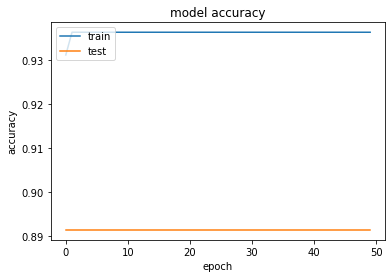

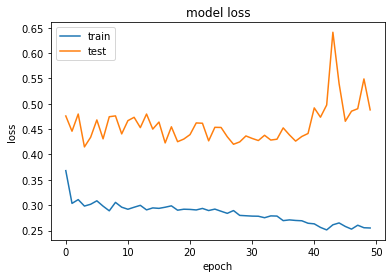

In [22]:
plot_fit(model_fit)

We check the performance of our model against the test data.

In [23]:
predictions = model.predict(test_input)
m = CategoricalAccuracy()
m.update_state(test_output, predictions)
print(f"Accuracy: {m.result().numpy()}")

Accuracy: 0.8700000047683716
